# Analyzing solving times of a world-class speedcuber - Philipp Weyer

**Speedcubing** is the activity of solving a variety of twisty puzzles as fast as possible. The most famous twisty puzzle from the Speedcubing domain (which is also responsible for shaping the term *Speedcubing*) is the widely-known [Rubik's Cube](https://en.wikipedia.org/wiki/Rubik%27s_Cube), or more generally **3x3x3 Cube** (since *Rubik's Cube* is technically a brand name). In recent years, the popularity of Speedcubing has grown exponentially all over the world, which can mainly be attributed to the efforts of its global governing body, the [World Cube Association (WCA)](https://www.worldcubeassociation.org/). In 2017 alone, there have been 925 WCA competitions in 88 different countries with 37547 distinct competitors.

One of these competitors is [Philipp Weyer](https://www.worldcubeassociation.org/persons/2010WEYE01). Philipp is currently (beginning of March 2018) placed 8th in the [3x3x3 Cube WCA world rankings](https://www.worldcubeassociation.org/results/events.php?eventId=333&regionId=&years=&show=100%2BPersons&average=Average) with an average of 6.77 seconds (for the WCA's *average of 5* format each competitor is alotted 5 attempts, the best and worst attempts are removed, and the arithmetic mean of the remaining 3 attempts counts for the competitor's result).

***Ok, that's all quite interesting, but what makes Philipp Weyer particularly interesting for data analysis?!***

To be able to achieve such astonishing results, world-class speedcubers like Philipp do a tremendous amount of practice solves at home. But while most speedcubers do not keep track of these results, **Philipp has accumulated a data set of *over 200.000 timed 3x3x3 solves* since November 2013! Moreover, Philipp has shared this data with me to analyze it!**

# Part I: Data wrangling & cleaning

In this first part of my analysis, I will import and clean Philipp's data set to enable further analysis. Moreover, I will extract the data of Philipp's official 3x3x3 results from the [WCA data base export](https://www.worldcubeassociation.org/results/misc/export.html).

* [Practice data](#Practice-data)
* [Official results](#Official-results)

If you want to skip this part and look at the analysis part right away, please have a look at [Part II: Data analysis](Part_2_data_analysis.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, re, glob

## Practice data

Philipp has provided his practice data as two separate *.csv files, one with 200.000 results and one with about 35.000.

In [2]:
files = glob.glob('raw_input/*.txt')
print(files)

['raw_input\\times.txt', 'raw_input\\times2.txt']


An initial inspection of the files revelead that both of the files contain 4 columns:

1. an ongoing index to count the number of solves
2. a timestamp for each solve
3. the time of each solve
4. the scramble sequence according to which a solve was scrambled

Let's load both files into dataframes and inspect them!

In [3]:
column_names = ['index','timestamp','value','scramble']
df1 = pd.read_csv(files[0], delimiter='\t+', header=None, engine='python', names=column_names, index_col='index')
df1.head()

,timestamp,value,scramble
index,,,
200000,25.04.2017 13:25:59,00:07.72,D R2 B2 U' R2 U' B2 D U2 F2 R' B U2 F D R2 F' ...
199999,25.04.2017 13:25:37,00:06.94,D L2 F2 U B2 R2 D' F2 U' R2 L2 B' R2 U2 B' D' ...
199998,25.04.2017 13:25:21,00:08.13,R2 B2 F2 U2 L2 F2 D2 L2 B2 D R2 F U2 B' F2 R2 ...
199997,25.04.2017 13:25:06,00:06.65,D R2 U' B2 L2 D2 R2 F2 D B2 U B D2 L' B U' R2 ...
199996,25.04.2017 13:24:52,00:06.93,L2 F2 D' B2 U' R2 D F2 U' F2 D F' U B' U' R2 L...


In [4]:
df2 = pd.read_csv(files[1], delimiter='\t+', header=None, engine='python', names=column_names, index_col='index')
df2.head()

,timestamp,value,scramble
index,,,
35163,"Feb 19, 2018, 7:55:33 PM",00:07.68,R2 B2 L2 U2 L2 F2 D' L2 U' R2 U' R D' F' L U2 ...
35162,"Feb 19, 2018, 7:46:17 PM",00:07.64,U' B2 F2 U2 L2 D' F2 D U2 R2 L2 B D2 L D' U B'...
35161,"Feb 19, 2018, 7:46:02 PM",00:06.73,L2 U' R2 B2 D' B2 L2 U2 B2 F2 U2 L' U F D' F2 ...
35160,"Feb 19, 2018, 7:45:49 PM",00:06.37,U2 B2 L2 D F2 R2 L2 F2 D L2 D' R' F' R B U R' ...
35159,"Feb 19, 2018, 7:45:36 PM",00:07.08,U' R2 B2 R2 L2 D U B2 U' R2 D' L F R' B' U' L2...


The first obvious problem of the data is that the timestamps have different format! Let's first ensure that the format is consistent within each dataframe.

In [5]:
# first file, example: 25.04.2017 13:25:59
pattern1 = '^\d{2}\.\d{2}\.\d{4} \d{2}\:\d{2}\:\d{2}$'
assert df1.timestamp.str.contains(pattern1).all()

# second file, example: Feb 19, 2018, 7:55:33 PM
pattern2 = '^[A-Z][a-z]{2} \d{1,2}\, \d{4}\, \d{1,2}\:\d{2}\:\d{2} [A-Z]{2}$'
assert df2.timestamp.str.contains(pattern2).all()

Awesome! So let's transform each column to a datetime type and merge the dataframes:

In [6]:
df1['timestamp'] = df1['timestamp'].apply(lambda x: pd.to_datetime(datetime.datetime.strptime(x, '%d.%m.%Y %H:%M:%S')))
df2['timestamp'] = df2['timestamp'].apply(lambda x: pd.to_datetime(datetime.datetime.strptime(x, '%b %d, %Y, %I:%M:%S %p')))
df = pd.concat([df1,df2])
df.head()

,timestamp,value,scramble
index,,,
200000,2017-04-25 13:25:59,00:07.72,D R2 B2 U' R2 U' B2 D U2 F2 R' B U2 F D R2 F' ...
199999,2017-04-25 13:25:37,00:06.94,D L2 F2 U B2 R2 D' F2 U' R2 L2 B' R2 U2 B' D' ...
199998,2017-04-25 13:25:21,00:08.13,R2 B2 F2 U2 L2 F2 D2 L2 B2 D R2 F U2 B' F2 R2 ...
199997,2017-04-25 13:25:06,00:06.65,D R2 U' B2 L2 D2 R2 F2 D B2 U B D2 L' B U' R2 ...
199996,2017-04-25 13:24:52,00:06.93,L2 F2 D' B2 U' R2 D F2 U' F2 D F' U B' U' R2 L...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235163 entries, 200000 to 1
Data columns (total 3 columns):
timestamp    235163 non-null datetime64[ns]
value        235163 non-null object
scramble     235163 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 7.2+ MB


As can be seen, the value column also needs to be converted to a float type:

In [8]:
value_pattern = '^\d{2}\:\d{2}\.\d{2}$'
assert df.value.str.contains(value_pattern).all()
df['value'] = df['value'].apply(lambda t: 60*int(str(t)[:2]) + float(str(t)[3:]))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235163 entries, 200000 to 1
Data columns (total 3 columns):
timestamp    235163 non-null datetime64[ns]
value        235163 non-null float64
scramble     235163 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.2+ MB


This looks good so far. In particular, no single missing value. However, this is also surprising, because in so many solves, one would also expect some attempts to be *messep up* and resulting in a failed attempt with an unsolved puzzle. I have talked about this with Philipp and he is clarified that he has deleted such attempt and that his has only occured very rarely (roughly once every 100-200 attempts). It should be said that this is a common practice for speedcubers while practicing at home, but it might be worth to keep this in mind for future analyses.

Time for some more pre-processing:

In [9]:
# the data frame should be sorted by timestamp...
df = df.sort_values(by='timestamp')

# ...and then reindexed
df = df.reset_index(drop=True)
df.index.name = 'index'

# finally, the scramble sequences won't be needed for any analysis. 
df = df.drop(columns=['scramble'])

df.head()

,timestamp,value
index,,
0,2013-11-16 21:53:57,9.45
1,2013-11-16 21:54:15,7.81
2,2013-11-16 21:55:55,11.89
3,2013-11-16 21:56:15,8.62
4,2013-11-16 21:56:33,12.80


Now, let's look at the values in the dataframe.

In [10]:
df.describe()

,value
count,235163.000000
mean,8.047875
std,1.197019
min,0.950000
25%,7.220000
50%,7.930000
75%,8.760000
max,20.460000


Pretty fast times! But the minimum value appears suspicious, let's examine this in detail:

In [11]:
df.sort_values('value').head()

,timestamp,value
index,,
228388,2017-12-15 19:49:31,0.95
232856,2018-01-28 11:43:33,3.19
225527,2017-11-06 21:50:59,3.59
223865,2017-10-21 23:04:26,3.72
173333,2016-11-12 21:05:02,3.75


Again, I have talked to Philipp and the lowest value, 0.95, is clearly an error. Therefore, I will replace it with the median of all solves of this particular day. Yet, the other times are correct, impressive!

In [12]:
error_index = df[df.value == 0.95].index[0]
df.loc[error_index,'value'] = df[df.timestamp.dt.date == datetime.date(2017,12,15)].value.median()
print('New value:', df.loc[error_index,'value'])
df.sort_values('value').head()

New value: 7.46


,timestamp,value
index,,
232856,2018-01-28 11:43:33,3.19
225527,2017-11-06 21:50:59,3.59
223865,2017-10-21 23:04:26,3.72
173333,2016-11-12 21:05:02,3.75
218739,2017-09-07 13:20:10,3.79


Time for some first visualization!

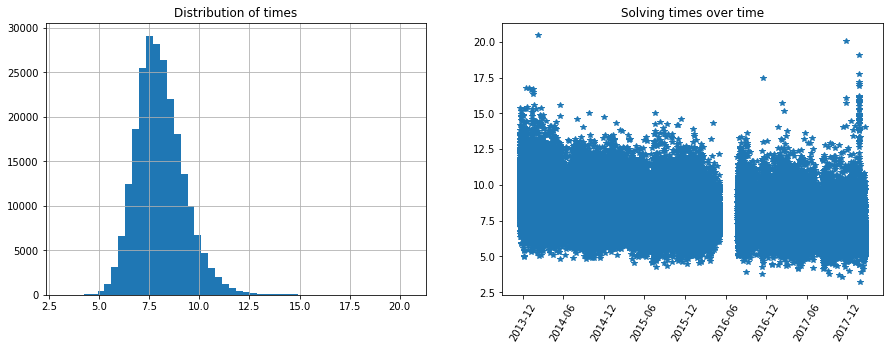

In [13]:
plt.figure(1, figsize=(15,5))
plt.subplot(121)
df['value'].hist(bins=50)
plt.title('Distribution of times')

plt.subplot(122)
plt.plot(df['timestamp'], df['value'], '*')
plt.xticks(rotation='60')
plt.title('Solving times over time')
plt.show();

As this does not give a good overview, I will look at per-day means instead:

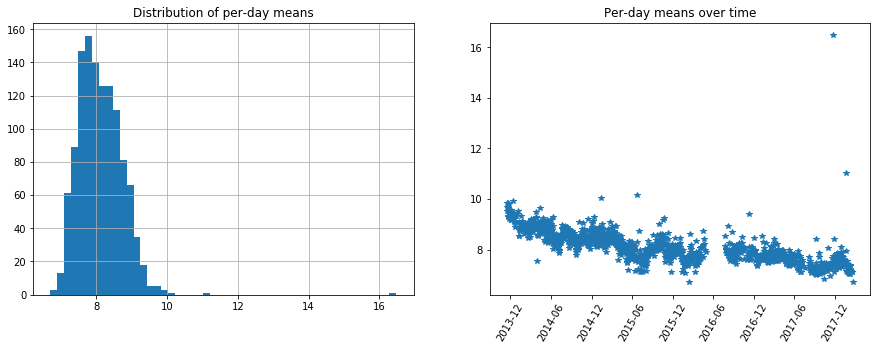

In [14]:
mean_per_day = df.groupby(df.timestamp.dt.date).mean()

plt.figure(1, figsize=(15,5))
plt.subplot(121)
mean_per_day['value'].hist(bins=50)
plt.title('Distribution of per-day means')

plt.subplot(122)
mean_per_day['value'].plot(style='*')
plt.xlabel('')
plt.xticks(rotation='60')
plt.title('Per-day means over time')
plt.show();

Again, something appears to be wrong given two massive outliers, so I will take a closer look:

In [15]:
mean_per_day[mean_per_day.value > 10]

,value
timestamp,
2015-01-12,10.025625
2015-06-22,10.150000
2017-11-22,16.482500
2018-01-20,11.025747


In [16]:
df[df.timestamp.dt.date == datetime.date(2017,11,22)]

,timestamp,value
index,,
227064,2017-11-22 20:48:52,14.10
227065,2017-11-22 20:49:21,16.09
227066,2017-11-22 21:07:34,15.69
227067,2017-11-22 21:16:42,20.05


In [17]:
df[df.timestamp.dt.date == datetime.date(2018,1,20)].iloc[[0,42,43,44,45,46,47,-1],:]

,timestamp,value
index,,
232003,2018-01-20 09:27:20,13.28
232045,2018-01-20 11:35:13,13.06
232046,2018-01-20 11:35:35,17.17
232047,2018-01-20 11:36:00,16.21
232048,2018-01-20 11:40:47,8.76
232049,2018-01-20 11:41:04,9.58
232050,2018-01-20 11:41:32,6.67
232089,2018-01-20 12:07:55,7.84


Once more, talking to Philipp helped clarifying this. Apparently, he has stored some OneHanded solves (solving a 3x3x3 Cube with only one hand) in his data by mistake. Therefore, I will drop the affected rows from 2017-11-22 and 2018-01-20 (daytime < 11:40:47).

In [18]:
# generate error index list
error_list = ((df.timestamp.dt.date == datetime.date(2017,11,22))
              | ((df.timestamp.dt.date == datetime.date(2018,1,20)) 
                 & (df.timestamp.dt.time < datetime.time(11,40,47))))
# the inverted index list should return 4 + 45 = 49 rows
error_list.sum()

49

In [19]:
index_list = (~error_list)
df = df[index_list]
df = df.reset_index(drop=True)
df.index.name = 'index'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235114 entries, 0 to 235113
Data columns (total 2 columns):
timestamp    235114 non-null datetime64[ns]
value        235114 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.6 MB


Alright! At last, let's once more check the per-day means over time for the fully cleaned dataframe.

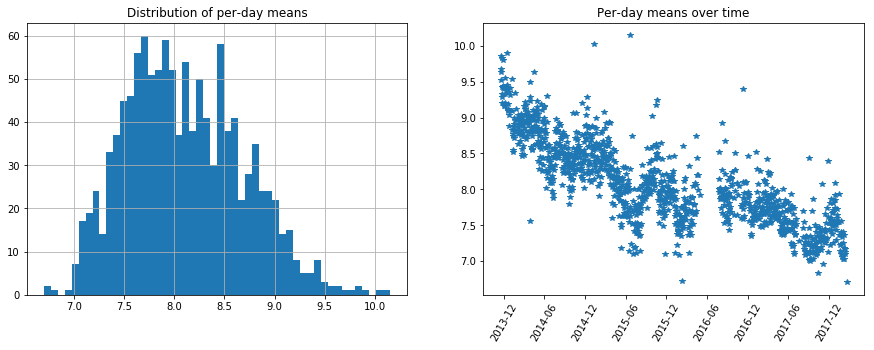

In [20]:
mean_per_day = df.groupby(df.timestamp.dt.date).mean()

plt.figure(1, figsize=(15,5))
plt.subplot(121)
mean_per_day['value'].hist(bins=50)
plt.title('Distribution of per-day means')

plt.subplot(122)
mean_per_day['value'].plot(style='*')
plt.xlabel('')
plt.xticks(rotation='60')
plt.title('Per-day means over time')
plt.show();

Perfect! Finally, save the cleaned practice data for future use.

In [21]:
df.to_csv('clean_data/practice_data.csv')
output = glob.glob('clean_data/practice_data.csv')
print(output)

['clean_data/practice_data.csv']


## Official results

After being done with cleaning Philipp's practice data, I will now fetch his official results from the 2018-02-26's WCA export. First, I import the results table from the WCA export. This gives us a very large dataframe with all results from official WCA competitions. 

In [22]:
results = pd.read_csv('db_export/WCA_export_Results.tsv', delimiter='\t')
results.head()

,competitionId,eventId,roundTypeId,pos,best,average,personName,personId,personCountryId,formatId,value1,value2,value3,value4,value5,regionalSingleRecord,regionalAverageRecord
0,LyonOpen2007,333,1,15,1968,2128,Etienne Amany,2007AMAN01,Cote d_Ivoire,a,1968,2203,2138,2139,2108,AfR,AfR
1,LyonOpen2007,333,1,16,1731,2140,Thomas Rouault,2004ROUA01,France,a,2222,2153,1731,2334,2046,NaN,NaN
2,LyonOpen2007,333,1,17,2305,2637,Antoine Simon-Chautemps,2005SIMO01,France,a,3430,2581,2540,2789,2305,NaN,NaN
3,LyonOpen2007,333,1,18,2452,2637,Irène Mallordy,2007MALL01,France,a,2715,2452,2868,2632,2564,NaN,NaN
4,LyonOpen2007,333,1,19,2677,2906,Marlène Desmaisons,2007DESM01,France,a,2921,3184,2891,2677,2907,NaN,NaN


However, I only want those of Philipp and only those from the 3x3x3 event. 

In [23]:
results = results[(results.eventId == '333') & (results.personId == '2010WEYE01')]
results.head()

,competitionId,eventId,roundTypeId,pos,best,average,personName,personId,personCountryId,formatId,value1,value2,value3,value4,value5,regionalSingleRecord,regionalAverageRecord
106819,CologneOpen2010,333,1,23,1278,1850,Philipp Weyer,2010WEYE01,Germany,a,2022,2277,1278,1447,2080,NaN,NaN
106950,CologneOpen2010,333,2,24,1591,1798,Philipp Weyer,2010WEYE01,Germany,a,2065,1591,1768,1859,1766,NaN,NaN
119472,EastGermanOpen2010,333,1,14,1331,1596,Philipp Weyer,2010WEYE01,Germany,a,1743,1738,1538,1331,1511,NaN,NaN
119530,EastGermanOpen2010,333,2,15,1438,1664,Philipp Weyer,2010WEYE01,Germany,a,1840,1806,1716,1471,1438,NaN,NaN
124272,Germany2010,333,1,25,1484,1573,Philipp Weyer,2010WEYE01,Germany,a,1593,1780,1627,1500,1484,NaN,NaN


Now, a lot of not needed columns can already be dropped for a better oversight. In particular, the column containing a round's average is not needed, since it only contains data that is directly derived from the individual times of a round.

In [24]:
value_columns = ['value' + str(i+1) for i in range(5)]
useful_columns = ['competitionId','roundTypeId'] + value_columns
results = results[useful_columns]
results.head()

,competitionId,roundTypeId,value1,value2,value3,value4,value5
106819,CologneOpen2010,1,2022,2277,1278,1447,2080
106950,CologneOpen2010,2,2065,1591,1768,1859,1766
119472,EastGermanOpen2010,1,1743,1738,1538,1331,1511
119530,EastGermanOpen2010,2,1840,1806,1716,1471,1438
124272,Germany2010,1,1593,1780,1627,1500,1484


It should already be noted that all the values are stored in centiseconds in the WCA database, but I will deal with this later.

Unfortunately, these official results do not come with any timestamps, in contrast to Philipp's practice data. But it is possible to obtain a date by matching the results with the competitions' dates, which can be found in the Competitions table of the WCA export.

In [25]:
# Fetching competition data
competition_data = pd.read_csv('db_export/WCA_export_Competitions.tsv', delimiter='\t', usecols=['id','year','month','day'])
competition_data.head()

,id,year,month,day
0,12SidesofSilesia2018,2018,3,3
1,150thCubeMeetinginBrest2017,2017,7,22
2,1AVG2013,2013,4,1
3,1BodyCubing2017,2017,6,3
4,2AVG2014,2014,2,2


For simplicity, I will use the first day of each competition. I first form a date out the three separate year, month, day columns, then I can merge this data with Philipp's official results.

In [26]:
def get_start_date(row):
    year, month, day = row['year'], row['month'], row['day']
    return pd.to_datetime(datetime.date(year,month,day).strftime('%Y-%m-%d'))

competition_data['date'] = competition_data.apply(get_start_date, axis=1)

dfo = results.merge(competition_data[['id','date']], how='inner', left_on='competitionId', right_on='id')
dfo = dfo[['date','competitionId','roundTypeId'] + value_columns]

dfo.head()

,date,competitionId,roundTypeId,value1,value2,value3,value4,value5
0,2010-06-12,CologneOpen2010,1,2022,2277,1278,1447,2080
1,2010-06-12,CologneOpen2010,2,2065,1591,1768,1859,1766
2,2010-08-14,EastGermanOpen2010,1,1743,1738,1538,1331,1511
3,2010-08-14,EastGermanOpen2010,2,1840,1806,1716,1471,1438
4,2010-09-11,Germany2010,1,1593,1780,1627,1500,1484


Now, let's have a look at the data.

In [27]:
dfo.describe()

,value1,value2,value3,value4,value5
count,180.000000,180.000000,180.000000,180.000000,180.000000
mean,910.988889,905.116667,917.477778,923.577778,928.183333
std,266.486198,257.811335,238.216498,253.374212,254.712840
min,-1.000000,-1.000000,562.000000,-1.000000,-1.000000
25%,746.250000,737.250000,746.250000,755.000000,766.000000
50%,834.500000,836.000000,853.000000,868.000000,858.500000
75%,973.500000,1028.500000,1012.500000,1017.500000,1068.250000
max,2065.000000,2277.000000,1941.000000,1993.000000,2080.000000


It can be seen that some value columns have a minimum value of -1. This is due to the fact that failed solving attempts, so-called DNFs ("Did Not Solve") are encoded by -1 in the WCA database. Let's look at this in detail.

In [28]:
DNF_rows = dfo.isin([-1]).any(axis=1)
dfo[DNF_rows]

,date,competitionId,roundTypeId,value1,value2,value3,value4,value5
9,2011-01-14,AachenOpen2011,1,1133,1483,1115,-1,1218
15,2011-04-09,GermanOpen2011,2,-1,1486,938,1030,1193
20,2011-05-28,GHSIngenhovenparkOpen2011,f,831,-1,1133,1231,1294
43,2012-06-23,AachenSummer2012,f,1305,1125,1146,1628,-1
71,2014-04-18,VelbertEasterOpen2014,1,969,771,783,769,-1


Lucky for me (and for Philipp), there is at most one DNF per round. Otherwise, Philipp's average for a round would also have been invalid (DNF). But this not being the case for any round allows me to impute the -1 values with the maximum value of the remaining attempts of the affected round, which does not affect the round's average (if computed).

In [29]:
dfo = dfo.replace(-1, np.nan)
# double-transpose is required here because the axis argument to fillna is not implemented
dfo = dfo.T.fillna(dfo[value_columns].max(axis=1)).T
dfo[DNF_rows]

,date,competitionId,roundTypeId,value1,value2,value3,value4,value5
9,2011-01-14 00:00:00,AachenOpen2011,1,1133,1483,1115,1483,1218
15,2011-04-09 00:00:00,GermanOpen2011,2,1486,1486,938,1030,1193
20,2011-05-28 00:00:00,GHSIngenhovenparkOpen2011,f,831,1294,1133,1231,1294
43,2012-06-23 00:00:00,AachenSummer2012,f,1305,1125,1146,1628,1628
71,2014-04-18 00:00:00,VelbertEasterOpen2014,1,969,771,783,769,969


The next problem to deal with is that the 5 individual solves per round are all stored in different columns. Fortunately, pandas provides an easy way to handle this.

In [30]:
dfo = pd.melt(dfo, id_vars=['date','competitionId','roundTypeId'], value_name='value', var_name='attempt')
dfo.head()

,date,competitionId,roundTypeId,attempt,value
0,2010-06-12,CologneOpen2010,1,value1,2022
1,2010-06-12,CologneOpen2010,2,value1,2065
2,2010-08-14,EastGermanOpen2010,1,value1,1743
3,2010-08-14,EastGermanOpen2010,2,value1,1840
4,2010-09-11,Germany2010,1,value1,1593


Time for some final pre-processing!

In [31]:
# Finally, it is time to convert the value columns of both dataframes from centiseconds to seconds. 
pd.options.mode.chained_assignment = None
dfo['value'] = dfo['value'].apply(lambda x: float(x) * 0.01)

# It is certainly more convenient to store the attempt indicators (value1, value2, ...) as integers (1,2,...) instead of strings 
dfo['attempt'] = dfo['attempt'].apply(lambda x: int(x[-1]))

# Also, the dataframe should be sorted by date, roundTypeId and attempt. Then, I reset its index.
dfo = dfo.sort_values(by=['date','roundTypeId','attempt'])
dfo = dfo.reset_index(drop=True)
dfo.index.name = 'index'

dfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 5 columns):
date             900 non-null datetime64[ns]
competitionId    900 non-null object
roundTypeId      900 non-null object
attempt          900 non-null int64
value            900 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 35.2+ KB


Just as for the practice data, let's have a look at some first visualization of Philipp's officiall results.

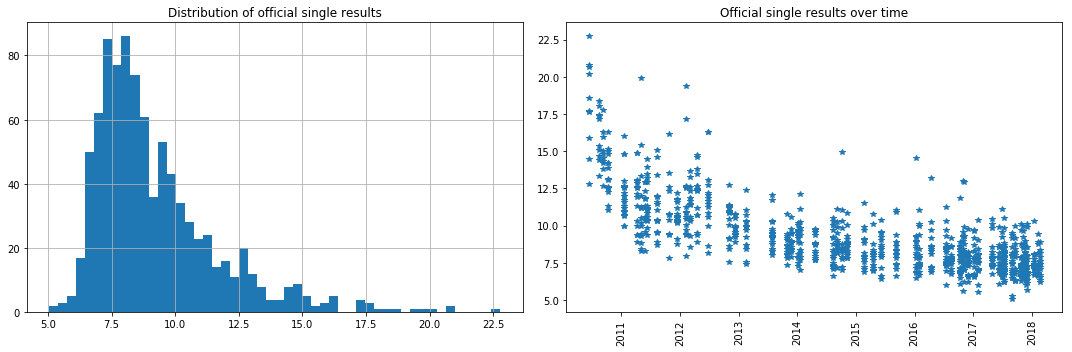

In [32]:
plt.figure(1, figsize=(15,5))

plt.subplot(121)
dfo['value'].hist(bins=50)
plt.title('Distribution of official single results')

plt.subplot(122)
plt.plot(dfo['date'], dfo['value'], '*')
plt.xticks(rotation='vertical')
plt.title('Official single results over time')

plt.tight_layout()
plt.show();

Great! As last step of this part, I save the cleaned official data for later use!

In [33]:
dfo.to_csv('clean_data/official_results.csv')
output = glob.glob('clean_data/*.csv')
print(output)

['clean_data\\official_results.csv', 'clean_data\\practice_data.csv']


**And that's it with the data wrangling & cleaning part! If you want to see further analysis check out [Part II: Data analysis](Part_2_data_analysis.ipynb)!**